#  Aplicando script de detección de cianobacteria de Sentinel Hub

In [118]:
import os
import json
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import matplotlib.dates as mdates
from scipy.signal import find_peaks




In [ ]:
lagos = {
    "lago_atitlan": {
        "west": -91.326256,
        "east": -91.07151,
        "south": 14.5948,
        "north": 14.750979
    },
    "lago_amatitlan": {
        "west": -90.638065,
        "east": -90.512924,
        "south": 14.412347,
        "north": 14.493799
    }
}

# Función para comparar bbox
def bbox_match(bbox, bbox_ref, tol=1e-4):
    return all(abs(a - b) < tol for a, b in zip(bbox, bbox_ref))

# Recorrer todas las carpetas en 'out'
ruta_out = "out"
imagenes_por_lago = {"lago_atitlan": [], "lago_amatitlan": []}

for carpeta in os.listdir(ruta_out):
    carpeta_path = os.path.join(ruta_out, carpeta)
    if not os.path.isdir(carpeta_path):
        continue
    # Leer el request.json
    request_path = os.path.join(carpeta_path, "request.json")
    if not os.path.exists(request_path):
        continue
    with open(request_path, "r") as f:
        req = json.load(f)
        print(req)
    bbox = req["request"]["payload"]["input"]["bounds"]["bbox"]
    # Extraer fecha del request.json si existe
    fecha = None
    input_payload = req["request"]["payload"]["input"]["data"][0]["dataFilter"]["timeRange"]
    print("-----")
    # print(input_payload)
    if "from" in input_payload:
        fecha = input_payload["from"]
        # print(fecha)
    elif "date" in input_payload:
        fecha = input_payload["date"]
    else:
        fecha = req["request"]["payload"].get("from", None)
    # Identificar lago
    lago = None
    if bbox_match(bbox, [lagos["lago_atitlan"]["west"], lagos["lago_atitlan"]["south"], lagos["lago_atitlan"]["east"], lagos["lago_atitlan"]["north"]]):
        lago = "lago_atitlan"
    elif bbox_match(bbox, [lagos["lago_amatitlan"]["west"], lagos["lago_amatitlan"]["south"], lagos["lago_amatitlan"]["east"], lagos["lago_amatitlan"]["north"]]):
        lago = "lago_amatitlan"
    else:
        print(f"Carpeta {carpeta} no coincide con ningún lago.")
        continue
    # Leer la imagen .tiff
    tiff_path = os.path.join(carpeta_path, "response.tiff")
    if not os.path.exists(tiff_path):
        print(f"No se encontró response.tiff en {carpeta}")
        continue
    with rasterio.open(tiff_path) as src:
        arr = src.read()  # (bandas, alto, ancho)
    imagenes_por_lago[lago].append({
        "carpeta": carpeta,
        "bbox": bbox,
        "arr": arr,
        "meta": src.meta,
        "fecha": fecha
    })

print(f"Imágenes encontradas por lago:")
for lago, imgs in imagenes_por_lago.items():
    print(f"{lago}: {len(imgs)} imágenes")

{'request': {'headers': {'accept': 'image/tiff', 'content-type': 'application/json'}, 'payload': {'evalscript': '\n    //VERSION=3\n    function setup() {\n        return {\n            input: [{\n                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],\n                units: "DN"\n            }],\n            output: {\n                bands: 13,\n                sampleType: "INT16"\n            }\n        };\n    }\n\n    function evaluatePixel(sample) {\n        return [sample.B01,\n                sample.B02,\n                sample.B03,\n                sample.B04,\n                sample.B05,\n                sample.B06,\n                sample.B07,\n                sample.B08,\n                sample.B8A,\n                sample.B09,\n                sample.B10,\n                sample.B11,\n                sample.B12];\n    }\n', 'input': {'bounds': {'bbox': [-90.638065, 14.412347, -90.512924, 14.493799], 'properties': {'crs': 'ht

# 4,5. Arreglos numpy y Script de cianobacteria

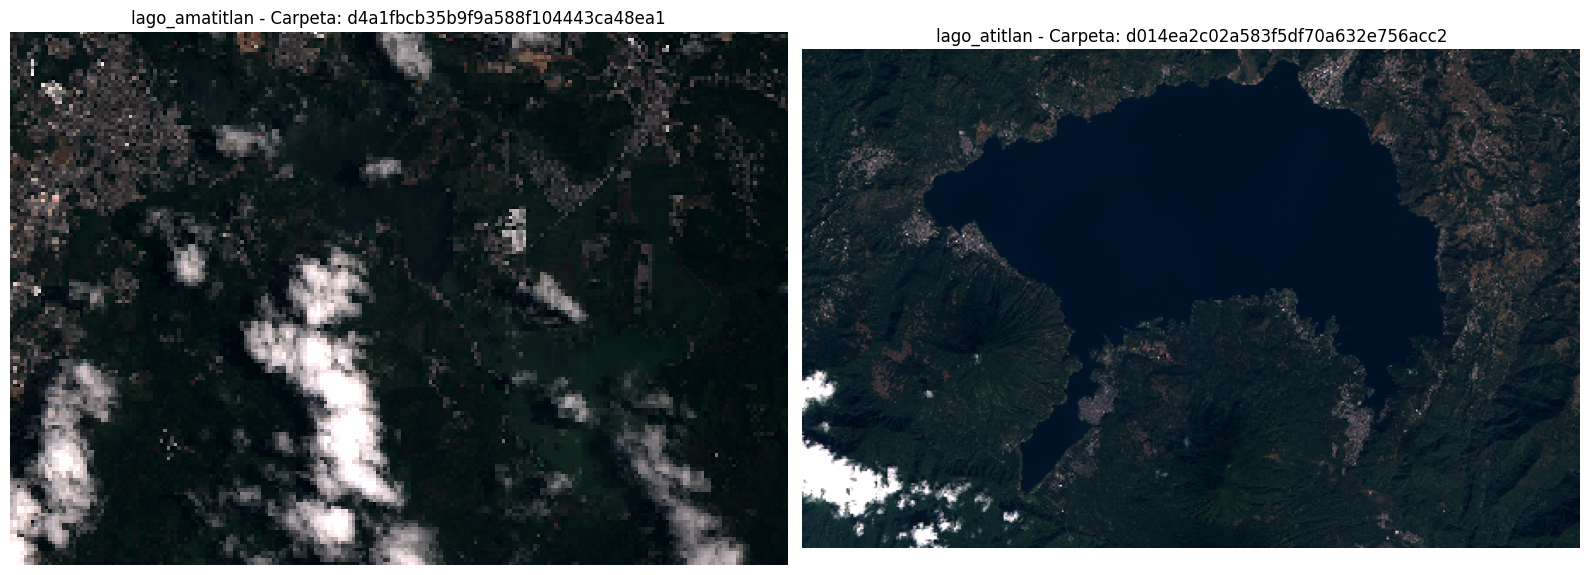

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for i, lago in enumerate(["lago_amatitlan", "lago_atitlan"]):
    if len(imagenes_por_lago[lago]) == 0:
        axes[i].set_title(f"{lago} (sin imágenes)")
        axes[i].axis('off')
        continue
    # Selecciona una imagen al azar
    img_info = random.choice(imagenes_por_lago[lago])
    arr = img_info["arr"]  # (bandas, alto, ancho)
    # Extrae bandas RGB (B04=rojo, B03=verde, B02=azul) índices 3,2,1
    rgb = np.stack([arr[3], arr[2], arr[1]], axis=-1).astype(float)
    rgb_min = np.percentile(rgb, 1)
    rgb_max = np.percentile(rgb, 99)
    rgb = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)
    axes[i].imshow(rgb)
    axes[i].set_title(f"{lago} - Carpeta: {img_info['carpeta']}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [109]:
# Eliminar imágenes "en blanco" (sin datos válidos o con baja variabilidad)
imagenes_por_lago_limpias = {"lago_atitlan": [], "lago_amatitlan": []}

for lago, lista_imgs in imagenes_por_lago.items():
    for img_info in lista_imgs:
        arr = img_info["arr"]  # (bandas, alto, ancho)
        # Verifica si la imagen tiene datos válidos en las bandas principales
        # Usamos B02 (azul), B03 (verde), B04 (rojo)
        b02 = arr[2]
        b03 = arr[3]
        b04 = arr[4]
        # Si la desviación estándar es muy baja, la imagen está "en blanco"
        if (
            np.std(b02) < 1e-3 or np.std(b03) < 1e-3 or np.std(b04) < 1e-3 or
            np.all(np.isnan(b02)) or np.all(np.isnan(b03)) or np.all(np.isnan(b04))
        ):
            print(f"Imagen {img_info['carpeta']} eliminada por estar en blanco o sin datos.")
            continue
        imagenes_por_lago_limpias[lago].append(img_info)

# Ahora realiza el filtrado de nubosidad sobre imagenes_por_lago_limpias
umbral_nubosidad = 0.2  # 20%
imagenes_filtradas = {"lago_atitlan": [], "lago_amatitlan": []}

for lago, lista_imgs in imagenes_por_lago_limpias.items():
    for img_info in lista_imgs:
        arr = img_info["arr"]  # (bandas, alto, ancho)
        b01 = arr[1]
        b09 = arr[9]
        b10 = arr[10]
        b02 = arr[2]
        b03 = arr[3]

        def norm_band(b):
            return (b - np.percentile(b, 1)) / (np.percentile(b, 99) - np.percentile(b, 1))

        b01n = norm_band(b01)
        b09n = norm_band(b09)
        b10n = norm_band(b10)
        b02n = norm_band(b02)
        b03n = norm_band(b03)

        cloud_index = (b01n + b09n + b10n + b02n + b03n) / 5
        mask_nube = cloud_index > np.percentile(cloud_index, 90)
        porcentaje_nuboso = np.mean(mask_nube)
        img_info["porcentaje_nuboso"] = porcentaje_nuboso

        if porcentaje_nuboso < umbral_nubosidad:
            imagenes_filtradas[lago].append(img_info)

print("Imágenes filtradas por baja nubosidad (<20%):")
for lago, imgs in imagenes_filtradas.items():
    print(f"{lago}: {len(imgs)} imágenes")

Imagen 05259b8347ce3e6a870bfcafc68154b6 eliminada por estar en blanco o sin datos.
Imagen 0c5e7cdbf6062c1fda8147e07e97b61c eliminada por estar en blanco o sin datos.
Imagen 109a3c776bd96eb3f34ac6150e96f063 eliminada por estar en blanco o sin datos.
Imagen 119b818a0158cc0860d7974518ea6556 eliminada por estar en blanco o sin datos.
Imagen 1549fa6779e0bc50a341de75d6bbd786 eliminada por estar en blanco o sin datos.
Imagen 16146e9a171cbbc3c478b4056e02bf1b eliminada por estar en blanco o sin datos.
Imagen 20a188afa974374319256814be636bc0 eliminada por estar en blanco o sin datos.
Imagen 2361c24415eb80d33a12632dace6bcfd eliminada por estar en blanco o sin datos.
Imagen 23c3b1986a0b62fca76affa0f759a7e6 eliminada por estar en blanco o sin datos.
Imagen 25fab7e8df581c6d2320abde0d7496a6 eliminada por estar en blanco o sin datos.
Imagen 29d4a112784b6b79b01176e34e14b868 eliminada por estar en blanco o sin datos.
Imagen 2a2d2b1c278be1763fa087ca998d6577 eliminada por estar en blanco o sin datos.
Imag

# 6. Análisis temporal 

lago_atitlan: 154 filas, fechas válidas: 154
lago_amatitlan: 154 filas, fechas válidas: 154


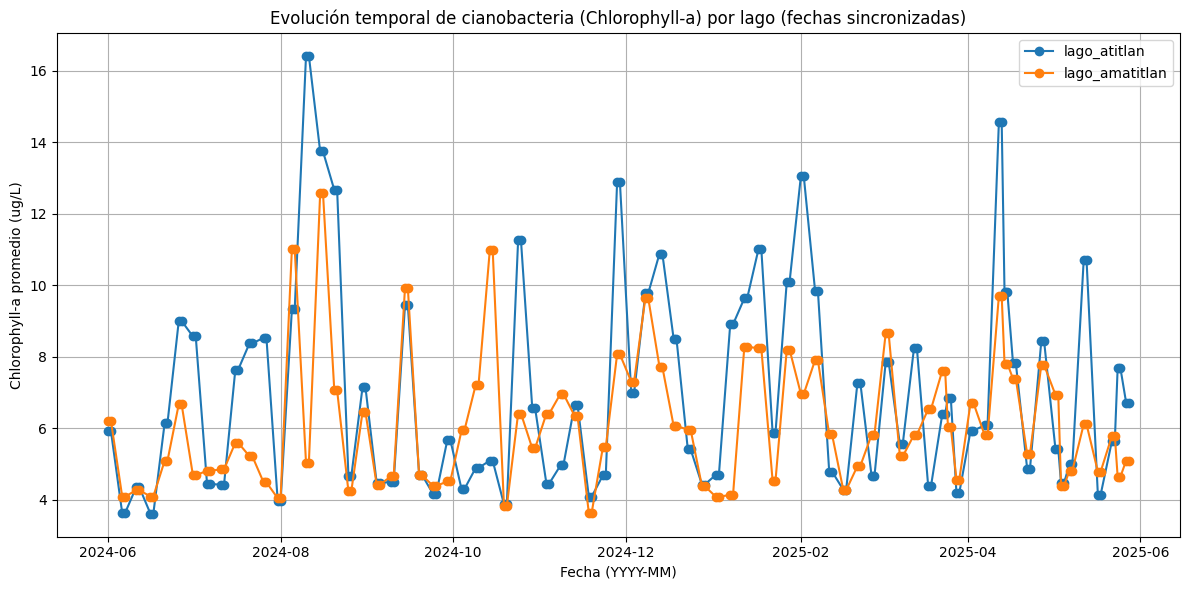

In [117]:
# Función para calcular NDCI y Chlorophyll-a
def calc_ndci_chla(arr):
    # Sentinel-2 L1C: B04 (665nm, índice 3), B05 (705nm, índice 4)
    b04 = arr[3].astype(float)
    b05 = arr[4].astype(float)
    ndci = (b05 - b04) / (b05 + b04 + 1e-6)
    chla = 826.57 * ndci**3 - 176.43 * ndci**2 + 19 * ndci + 4.071
    # Solo valores positivos y razonables
    chla = np.clip(chla, 0, 500)
    return ndci, chla

resultados = []
for lago, lista_imgs in imagenes_filtradas.items():
    for img_info in lista_imgs:
        arr = img_info["arr"]
        ndci, chla = calc_ndci_chla(arr)
        mascara_valida = (arr[3] > 0) & (arr[4] > 0)
        
        #promedio
        chla_mean = np.mean(chla[mascara_valida])
        # Usa la fecha extraída del request.json
        fecha = img_info.get("fecha", None)
        resultados.append({"lago": lago, "fecha": fecha, "chla_mean": chla_mean})

df = pd.DataFrame(resultados)
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")

# Filtra fechas para que ambos lagos usen solo las fechas presentes en lago_amatitlan
fechas_amatitlan = df[df["lago"] == "lago_amatitlan"]["fecha"].dropna().unique()
df_filtrado = df[df["fecha"].isin(fechas_amatitlan)]

for lago in df_filtrado["lago"].unique():
    df_lago = df_filtrado[df_filtrado["lago"] == lago]
    print(f"{lago}: {len(df_lago)} filas, fechas válidas: {df_lago['fecha'].notnull().sum()}")

plt.figure(figsize=(12,6))
ax = plt.gca()
for lago in df_filtrado["lago"].unique():
    df_lago = df_filtrado[df_filtrado["lago"] == lago].sort_values("fecha")
    plt.plot(df_lago["fecha"], df_lago["chla_mean"], marker="o", label=lago)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xlabel("Fecha (YYYY-MM)")
plt.ylabel("Chlorophyll-a promedio (ug/L)")
plt.title("Evolución temporal de cianobacteria (Chlorophyll-a) por lago (fechas sincronizadas)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Picos de floración y fechas críticas.

Los "picos de floración" son los puntos donde el valor promedio de Chlorophyll-a aumenta notablemente respecto a otros momentos. Estos picos suelen indicar eventos de proliferación de cianobacterias, conocidos como floraciones, que pueden afectar la calidad del agua y la salud ambiental.

Las "fechas críticas" corresponden a los momentos en que se observan estos picos, es decir, las fechas donde los valores de Chlorophyll-a son máximos o significativamente elevados.



In [119]:
# Identificar picos de floración y fechas críticas para cada lago

# Usar el DataFrame filtrado del análisis temporal
for lago in df_filtrado["lago"].unique():
    df_lago = df_filtrado[df_filtrado["lago"] == lago].sort_values("fecha")
    chla = df_lago["chla_mean"].values
    fechas = df_lago["fecha"].values
    # Encuentra picos locales (floraciones)
    indices_picos, _ = find_peaks(chla, prominence=2)  # prominence ajusta sensibilidad
    print(f"\n{lago} - Picos de floración detectados:")
    for idx in indices_picos:
        print(f"Fecha: {fechas[idx].astype('M8[D]')}, Chlorophyll-a: {chla[idx]:.2f} ug/L")
    # También muestra el máximo absoluto
    idx_max = chla.argmax()
    print(f"Máximo absoluto: Fecha: {fechas[idx_max].astype('M8[D]')}, Chlorophyll-a: {chla[idx_max]:.2f} ug/L")


lago_atitlan - Picos de floración detectados:
Fecha: 2024-06-26, Chlorophyll-a: 9.00 ug/L
Fecha: 2024-07-26, Chlorophyll-a: 8.53 ug/L
Fecha: 2024-08-10, Chlorophyll-a: 16.42 ug/L
Fecha: 2024-08-30, Chlorophyll-a: 7.16 ug/L
Fecha: 2024-09-14, Chlorophyll-a: 9.45 ug/L
Fecha: 2024-10-24, Chlorophyll-a: 11.27 ug/L
Fecha: 2024-11-13, Chlorophyll-a: 6.66 ug/L
Fecha: 2024-11-28, Chlorophyll-a: 12.88 ug/L
Fecha: 2024-12-13, Chlorophyll-a: 10.89 ug/L
Fecha: 2025-01-17, Chlorophyll-a: 11.01 ug/L
Fecha: 2025-02-01, Chlorophyll-a: 13.06 ug/L
Fecha: 2025-02-21, Chlorophyll-a: 7.28 ug/L
Fecha: 2025-03-03, Chlorophyll-a: 7.87 ug/L
Fecha: 2025-03-13, Chlorophyll-a: 8.26 ug/L
Fecha: 2025-03-25, Chlorophyll-a: 6.86 ug/L
Fecha: 2025-04-12, Chlorophyll-a: 14.56 ug/L
Fecha: 2025-04-27, Chlorophyll-a: 8.43 ug/L
Fecha: 2025-05-12, Chlorophyll-a: 10.71 ug/L
Máximo absoluto: Fecha: 2024-08-10, Chlorophyll-a: 16.42 ug/L

lago_amatitlan - Picos de floración detectados:
Fecha: 2024-06-26, Chlorophyll-a: 6.68 ug/

## Lago Atitlán

Los picos de Chlorophyll-a son más altos y frecuentes, con el máximo absoluto en agosto 2024 (16.42 ug/L). Esto indica eventos de floración más intensos y recurrentes, especialmente entre julio y abril. Las fechas con valores elevados pueden estar asociadas a condiciones ambientales favorables para el crecimiento de cianobacterias (temperatura, nutrientes, lluvias).

## Lago Amatitlán

 Los picos son menos intensos, con el máximo absoluto en agosto 2024 (12.58 ug/L). Las floraciones ocurren en fechas similares, pero con menor magnitud. Esto sugiere que, aunque ambos lagos presentan eventos críticos, Atitlán tiene mayor riesgo de proliferación.
